### TYK2 Summary Statistic Aggregation Across Concentrations

When modeling DMS data, we currently consider each IFN-alpha concentration as a qualitatively distinct factor level. This enables pairwise comparisons between each tested condition and, say, a normalizer condition. However, it does not summarize trends in variant effect _across_ concentrations.

We would like to capture these trends to: i) increase power for effect detection in general, ii) interpret patterns across concentrations, and iii) generate a single variant-level score for comparison with genetic and other data types. There are a few ways we can approach this problem:

1. [Clustering](#part1)
2. [Meta-Regression](#part2)
3. [BMS-986202 Concentration Gradient](#part3)

In [89]:
library(png)
library(brms)
library(broom.mixed)
library(furrr)
library(knitr)
library(scales)
library(scico)
library(pheatmap)
library(ggnewscale)
library(ggalluvial)
library(ggpubr)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

#### Clustering <a name="part1"></a>

One approach is use clusering to group variants together with similar trajectories across concentrations or conditions. To do this, we define a vector for each variant containing either the effect size (log2FoldChange) or Z-statistic across concentrations. Across all variants, this is what all the trajectories look like: 

In [57]:
sumstats <- read_tsv("sumstats/tyk2_full_comparisons.tsv")

sumstat_mat_z <- sumstats %>%
    filter(grepl(" - IFNbeta100", condition), !chunk %in% c(9, 16)) %>%
    mutate(condition = gsub(" - IFNbeta100", "", condition)) %>%
    group_by(pos, aa) %>%
    #filter(sum(p.adj < 0.01) > 0) %>%
    select(pos, aa, statistic, condition) %>%
    pivot_wider(names_from = condition, values_from = statistic)

sumstat_mat_lfc <- sumstats %>%
    filter(grepl(" - IFNbeta100", condition), !chunk %in% c(9, 16)) %>%
    mutate(condition = gsub(" - IFNbeta100", "", condition)) %>%
    group_by(pos, aa) %>%
    #filter(sum(p.adj < 0.01) > 0) %>%
    select(pos, aa, log2FoldChange, condition) %>%
    pivot_wider(names_from = condition, values_from = log2FoldChange)

sumstat_mat_z$clusters <- kmeans(x = sumstat_mat_z[,-1:-2], centers = 4)$cluster
sumstat_mat_lfc$clusters <- kmeans(x = sumstat_mat_lfc[,-1:-2], centers = 4)$cluster

Rows: 236490 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, log2FoldChange, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


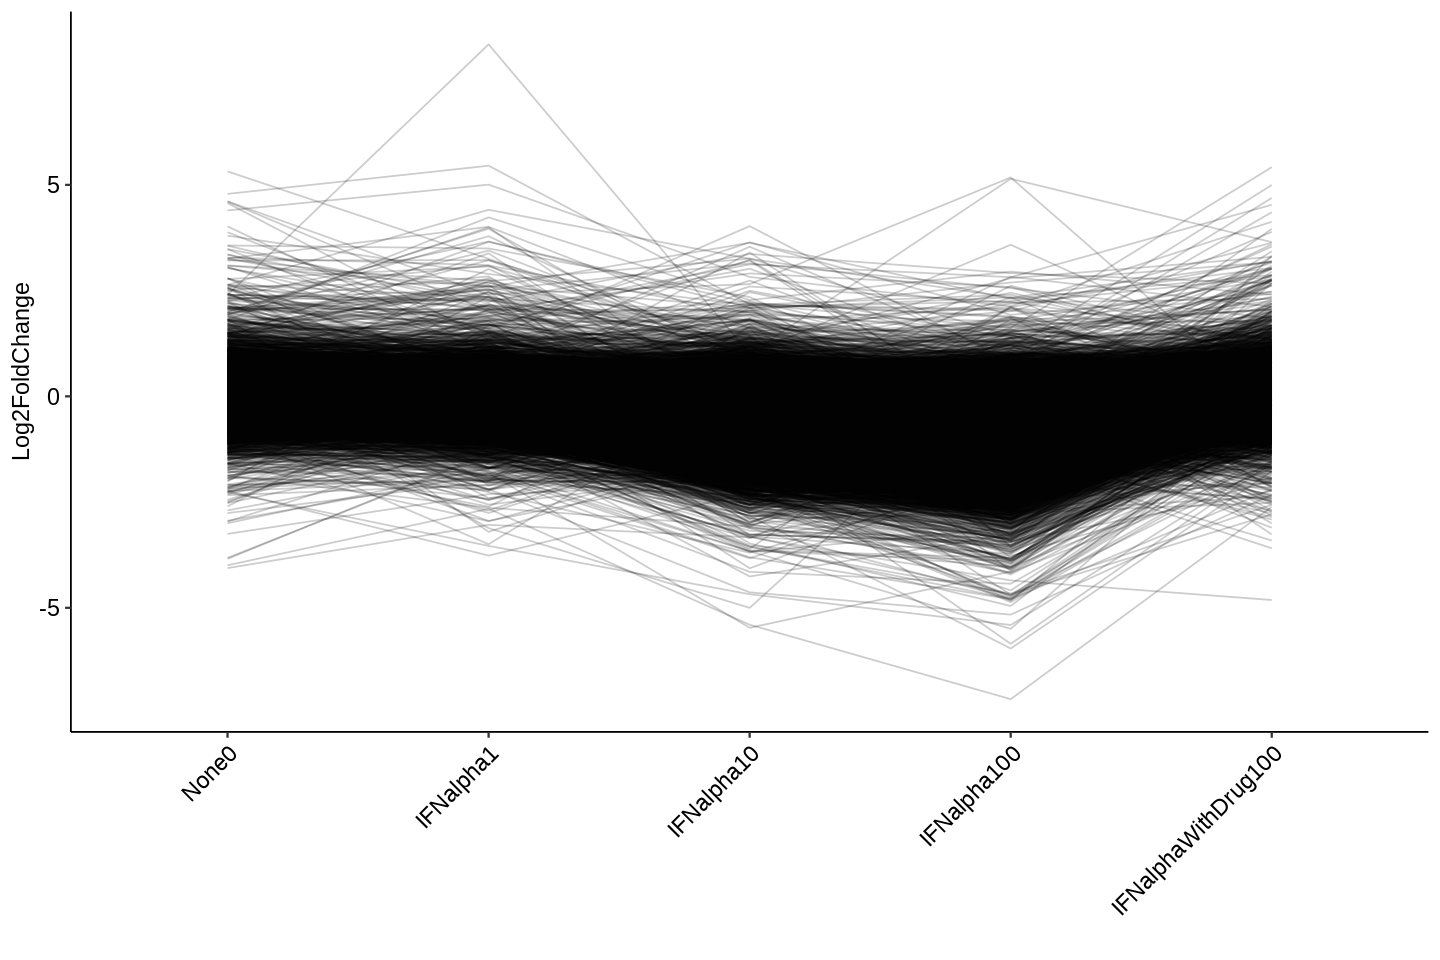

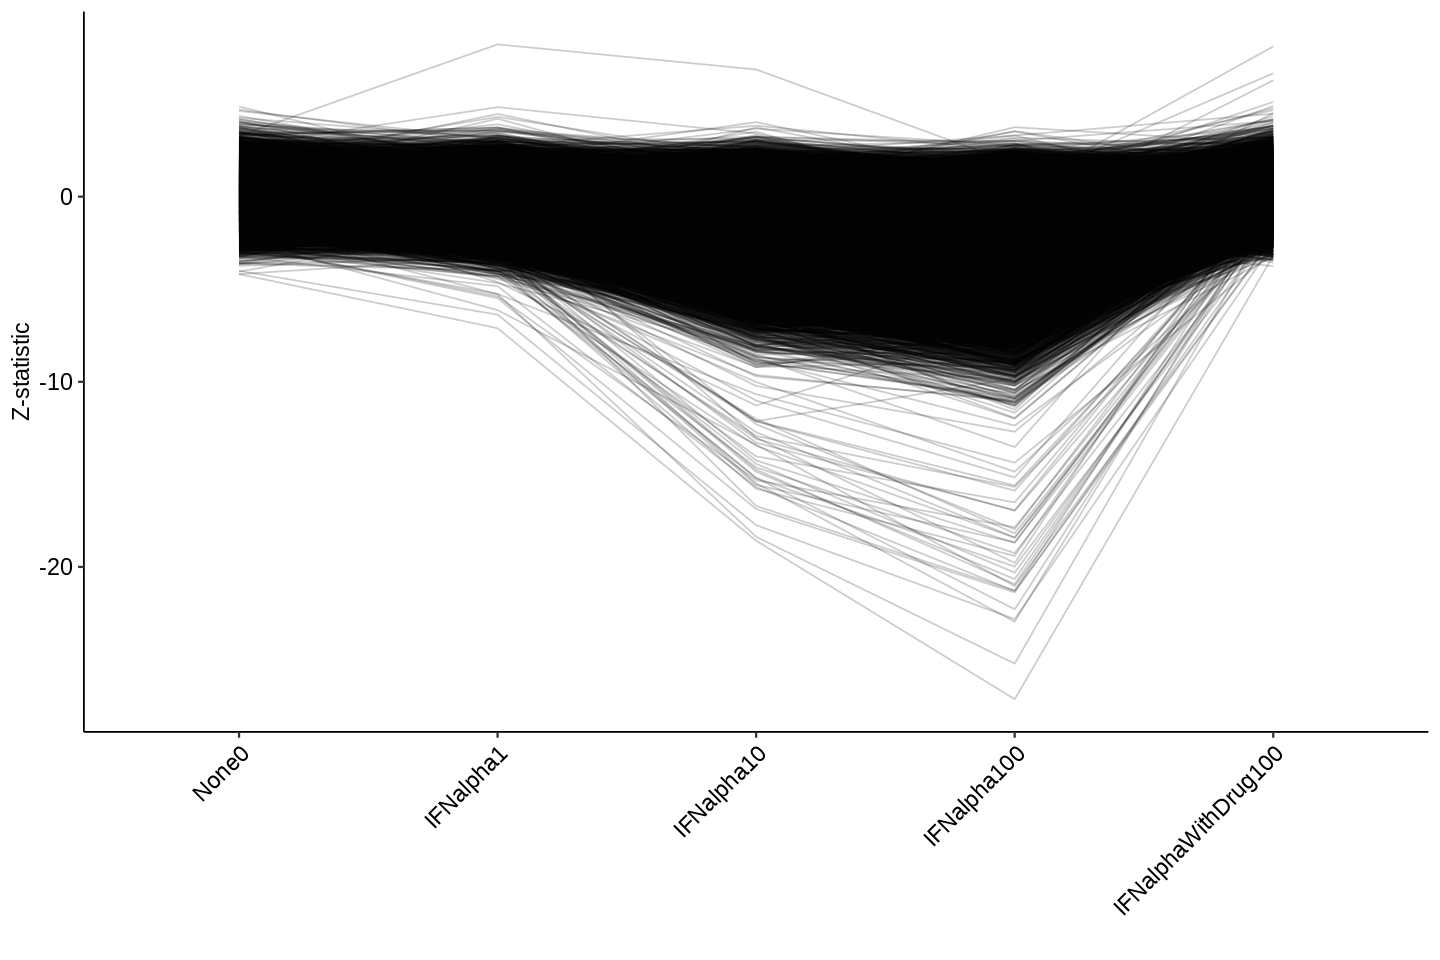

In [43]:
options(repr.plot.width = 12, repr.plot.height = 8)

sumstats %>%
    filter(grepl("- IFNbeta100", condition)) %>%
    mutate(condition = gsub(" - IFNbeta100", "", condition),
           condition = relevel(as.factor(condition), ref = "None0")) %>%
    ggplot() +
        geom_line(aes(x = condition, y = log2FoldChange, group = str_c(pos, aa)), alpha = 0.2) +
        theme_pubr(base_size = 14, x.text.angle = 45) +
        xlab("") + ylab("Log2FoldChange")

sumstats %>%
    filter(grepl("- IFNbeta100", condition)) %>%
    mutate(condition = gsub(" - IFNbeta100", "", condition),
           condition = relevel(as.factor(condition), ref = "None0")) %>%
    ggplot() +
        geom_line(aes(x = condition, y = statistic, group = str_c(pos, aa)), alpha = 0.2) +
        theme_pubr(base_size = 14, x.text.angle = 45) +
        xlab("") + ylab("Z-statistic")

Now, we can cluster each of these trajectory sets to group similar variants together. The choice of clustering metric and of the number of clusters are non-trivial, but based on the above there are not _that_ many patterns we need to detect. Some manual experimentation suggested that `k=3` clusters may be the most informative:

In [58]:
lfc_clust_id <- sumstat_mat_lfc %>% 
    pivot_longer(names_to = "condition", values_to = "Log2FoldChange", IFNalpha1:None0) %>%
    group_by(clusters) %>%
    summarize(med = median(Log2FoldChange)) %>%
    mutate(order_lfc = order(med)) %>%
    select(-med) 

z_clust_id <- sumstat_mat_z %>% 
    pivot_longer(names_to = "condition", values_to = "statistic", IFNalpha1:None0) %>%
    group_by(clusters) %>%
    summarize(med = median(statistic)) %>%
    mutate(order_z = order(med)) %>%
    select(-med) 


clust_ids <- inner_join(lfc_clust_id, z_clust_id, by = "clusters") %>%
    rename("display" = "clusters")

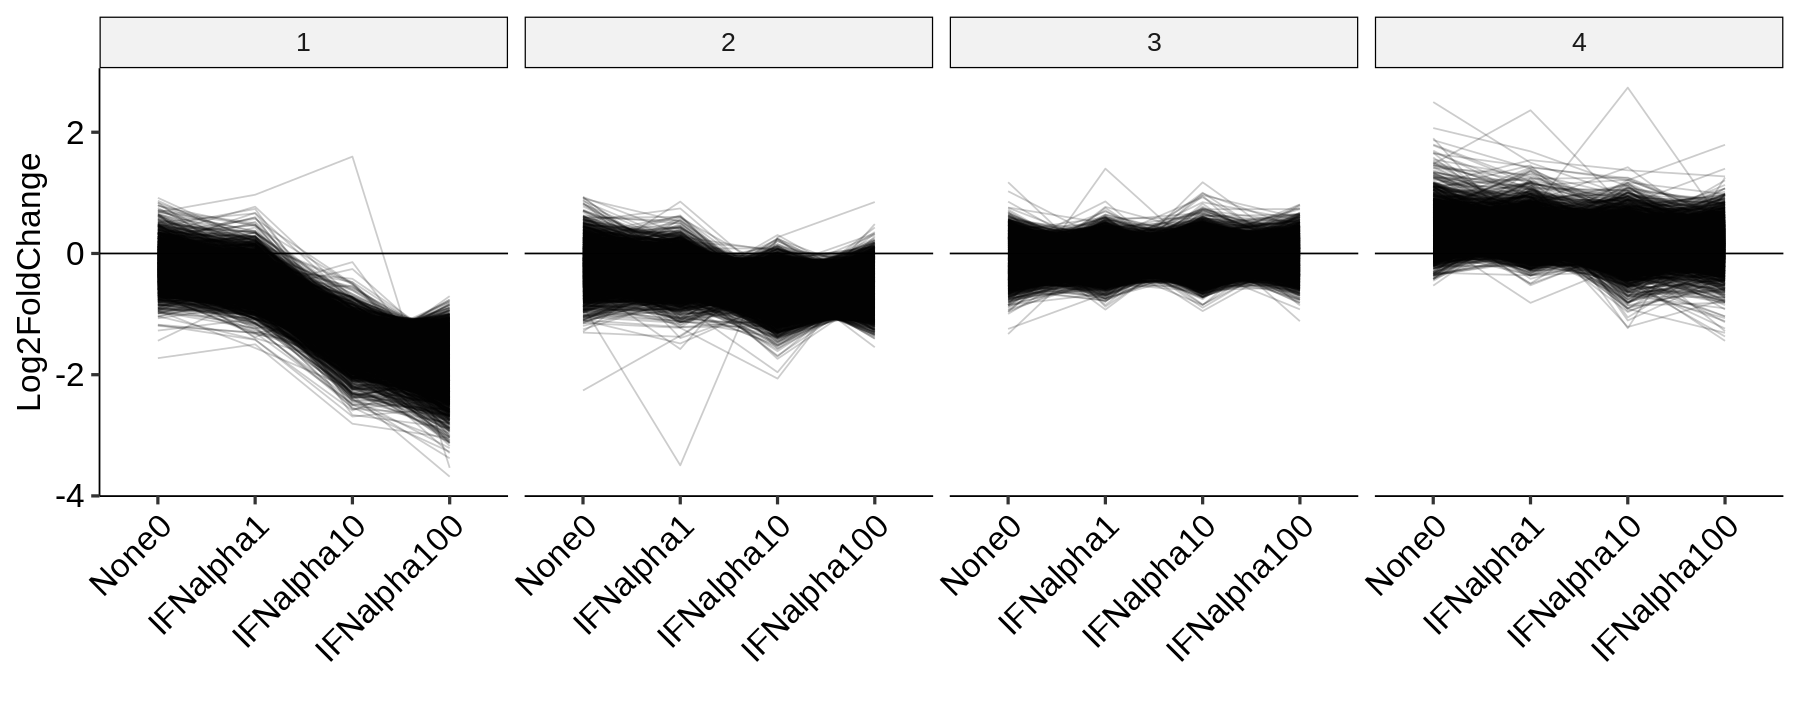

In [59]:
options(repr.plot.width = 15, repr.plot.height = 6)

sumstat_mat_lfc %>%
    pivot_longer(names_to = "condition", values_to = "Log2FoldChange", IFNalpha1:None0) %>%
    filter(condition != "IFNalphaWithDrug100") %>%
    mutate(condition = relevel(factor(condition), ref = "None0")) %>%
    left_join(clust_ids, by = c("clusters" = "order_lfc")) %>% 
    ggplot() +
        geom_hline(yintercept = 0) +
        geom_line(aes(x = condition, y = Log2FoldChange, group = paste0(pos, aa)), alpha = 0.2) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        xlab("") + ylab("Log2FoldChange") +
        facet_wrap(~display, nrow = 1)

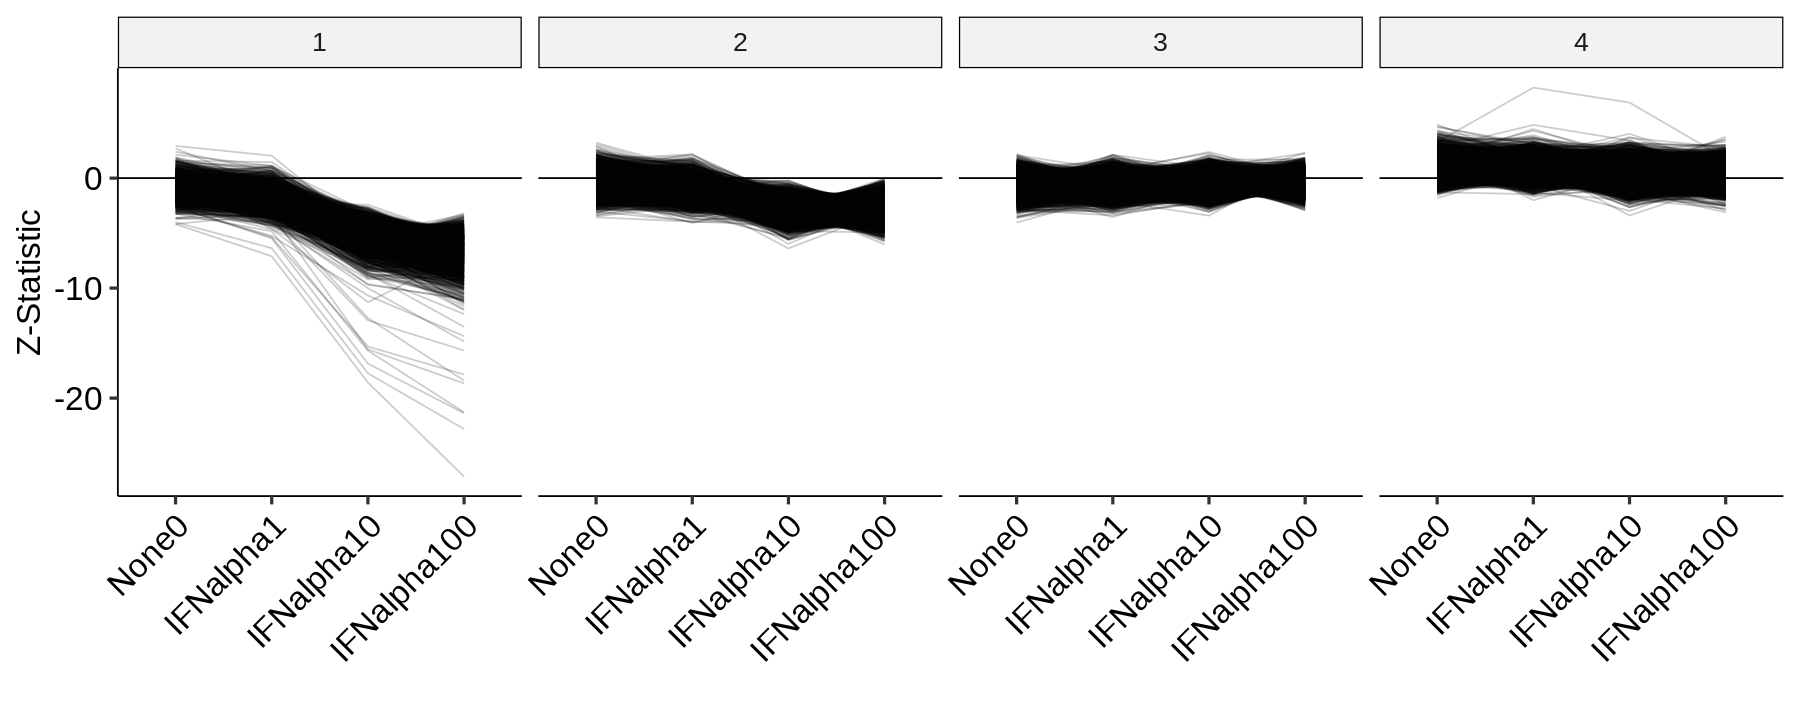

In [60]:
options(repr.plot.width = 15, repr.plot.height = 6)

sumstat_mat_z %>%
    pivot_longer(names_to = "condition", values_to = "statistic", IFNalpha1:None0) %>%
    filter(condition != "IFNalphaWithDrug100") %>%
    mutate(condition = relevel(factor(condition), ref = "None0")) %>%
    left_join(clust_ids, by = c("clusters" = "order_z")) %>% 
    ggplot() +
        geom_hline(yintercept = 0) +
        geom_line(aes(x = condition, y = statistic, group = paste0(pos, aa)), alpha = 0.2) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        xlab("") + ylab("Z-Statistic") +
        facet_wrap(~display, nrow = 1)

Immediately, clusters 1 and 2 appear to represent the strongest LoF and intermediate/partial LoF respectively. Cluster 4 is interesting, as it contains variants with mostly positive effect sizes across all conditions, meaning these are variants whose activity was lowest in the `IFNbeta100` condition (so that any other condition "looks" positive relative to `IFNbeta100`). It also contains the single significant GoF variant at the lower IFN-alpha concentrations. We can see how consistent the two clusterings are:

In [64]:
joined_clust <- inner_join(sumstat_mat_lfc %>% left_join(clust_ids, by = c("clusters" = "order_lfc")) %>% select(pos, aa, display),
                              sumstat_mat_z  %>% left_join(clust_ids, by = c("clusters" = "order_z"))  %>% select(pos, aa, display),
                              by = c("pos", "aa"))

cluster_compare <- joined_clust %>%
    rename("clusters_lfc" = "display.x", "clusters_z" = "display.y") %>% 
    ungroup() %>%
    select(-pos, -aa) %>% 
    group_by_all() %>%
    count()

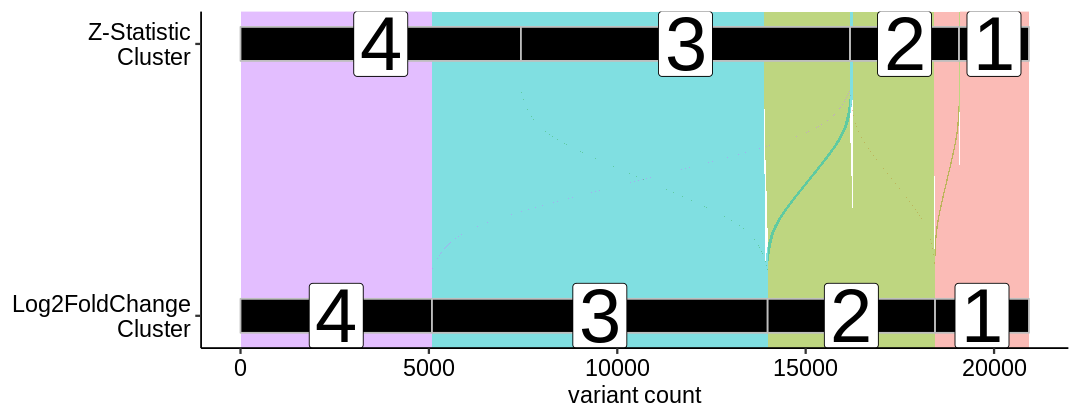

In [62]:
options(repr.plot.width = 9, repr.plot.height = 3.5, warn = -1)

cluster_compare %>%
    ggplot(aes(y = n, axis1 = clusters_lfc, axis2 = clusters_z)) +
        geom_alluvium(aes(fill = as.factor(clusters_lfc))) +
        geom_stratum(width = 1/8, fill = "black", color = "grey") +
        geom_label(stat = "stratum", aes(label = after_stat(stratum)), size = 16) +
        scale_x_continuous(breaks = c(1,2), labels = c("Log2FoldChange\nCluster",
                                                       "Z-Statistic\nCluster")) +
        theme_pubr(base_size = 14) +
        theme(legend.position = "none") +
        ylab("variant count") +
        coord_flip()

Clusters also allow us to modify some other visualizations to look for additional patterns, for example enrichments by residue:

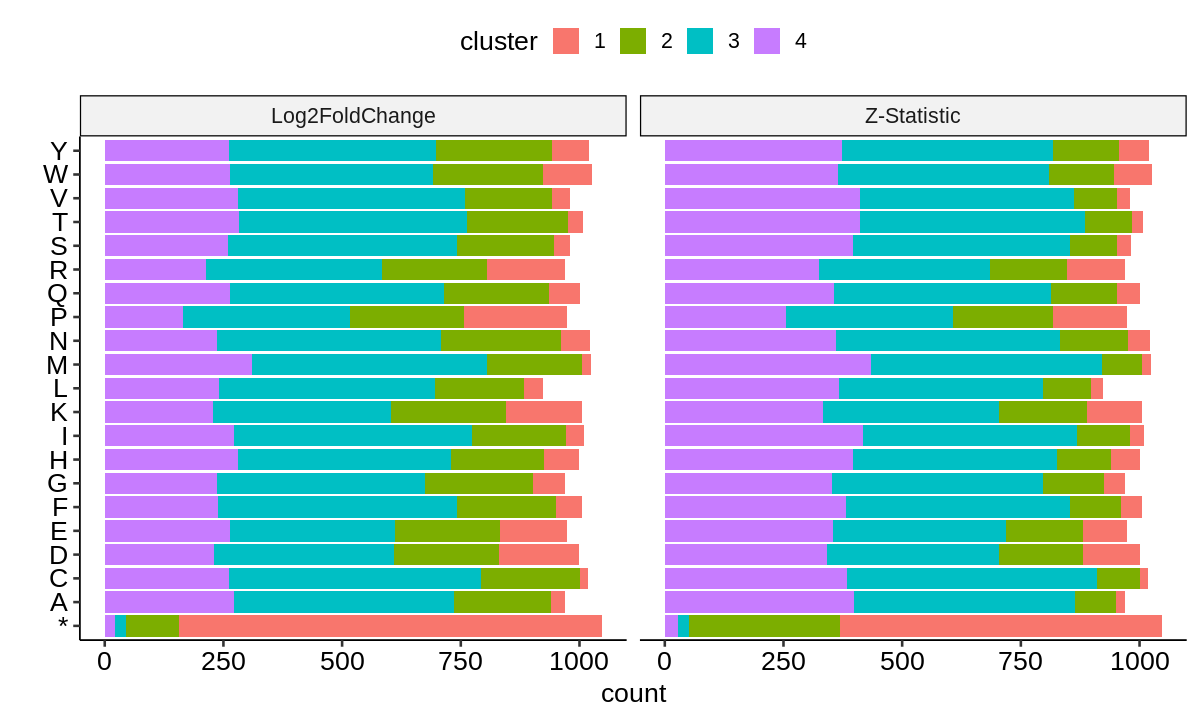

In [66]:
options(repr.plot.width = 10, repr.plot.height = 6)

joined_clust %>%
    rename("Log2FoldChange" = "display.x", "Z-Statistic" = "display.y") %>% 
    pivot_longer(names_to = "group", values_to = "cluster", Log2FoldChange:`Z-Statistic`) %>%
    ggplot() +
        geom_bar(aes(x = aa, fill = as.factor(cluster)), stat = "count") +
        theme_pubr(base_size = 16) +
        facet_wrap(~group) +
        xlab("") +
        coord_flip() +
        scale_fill_discrete(name = "cluster")

For positional enrichments, we can show the clusters via a heatmap, or as a count of the number of variants in each cluster at each position:

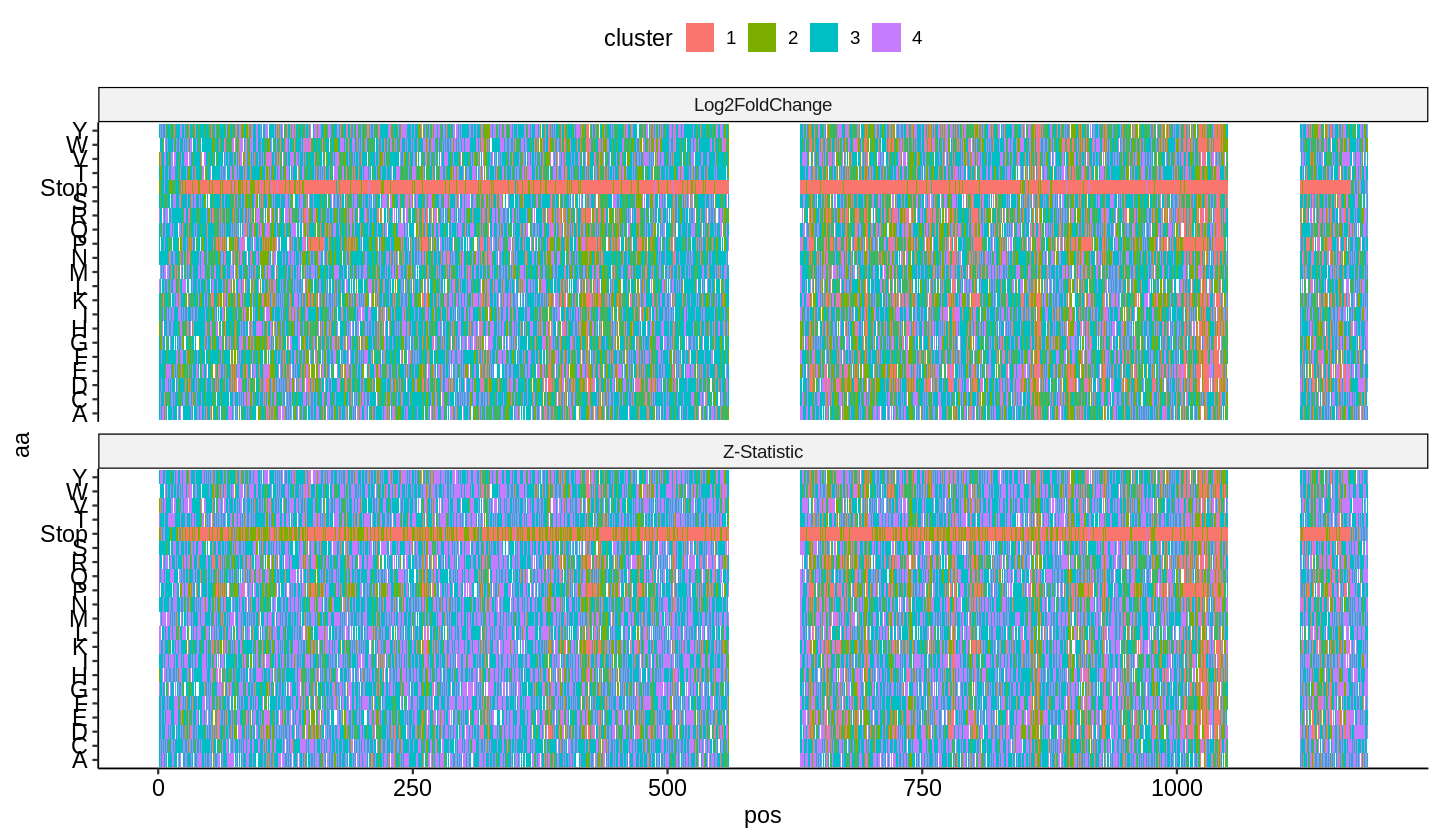

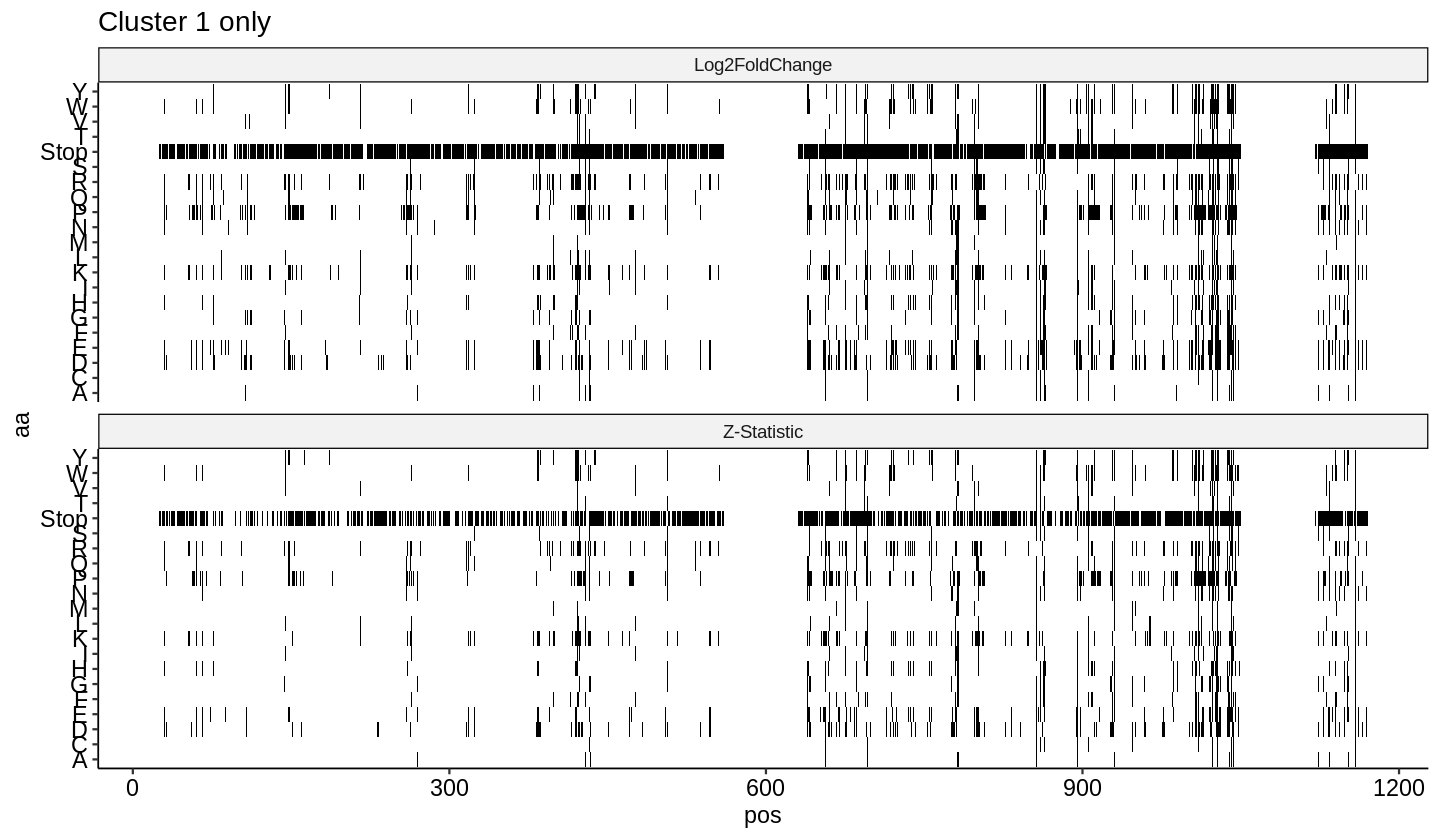

In [71]:
options(repr.plot.width = 12, repr.plot.height = 7)

joined_clust %>%
    rename("Log2FoldChange" = "display.x", "Z-Statistic" = "display.y") %>% 
    pivot_longer(names_to = "group", values_to = "cluster", Log2FoldChange:`Z-Statistic`) %>%
    mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
        geom_tile(aes(y = aa, x = pos, fill = as.factor(cluster))) +
        theme_pubr(base_size = 14) +
        facet_wrap(~group, ncol = 1) +
        scale_fill_discrete(name = "cluster")

joined_clust %>%
    rename("Log2FoldChange" = "display.x", "Z-Statistic" = "display.y") %>% 
    pivot_longer(names_to = "group", values_to = "cluster", Log2FoldChange:`Z-Statistic`) %>%
    mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
    filter(cluster == 1) %>%
    ggplot() +
        geom_tile(aes(y = aa, x = pos), fill = "black") +
        theme_pubr(base_size = 14) +
        facet_wrap(~group, ncol = 1) +
        ggtitle("Cluster 1 only")

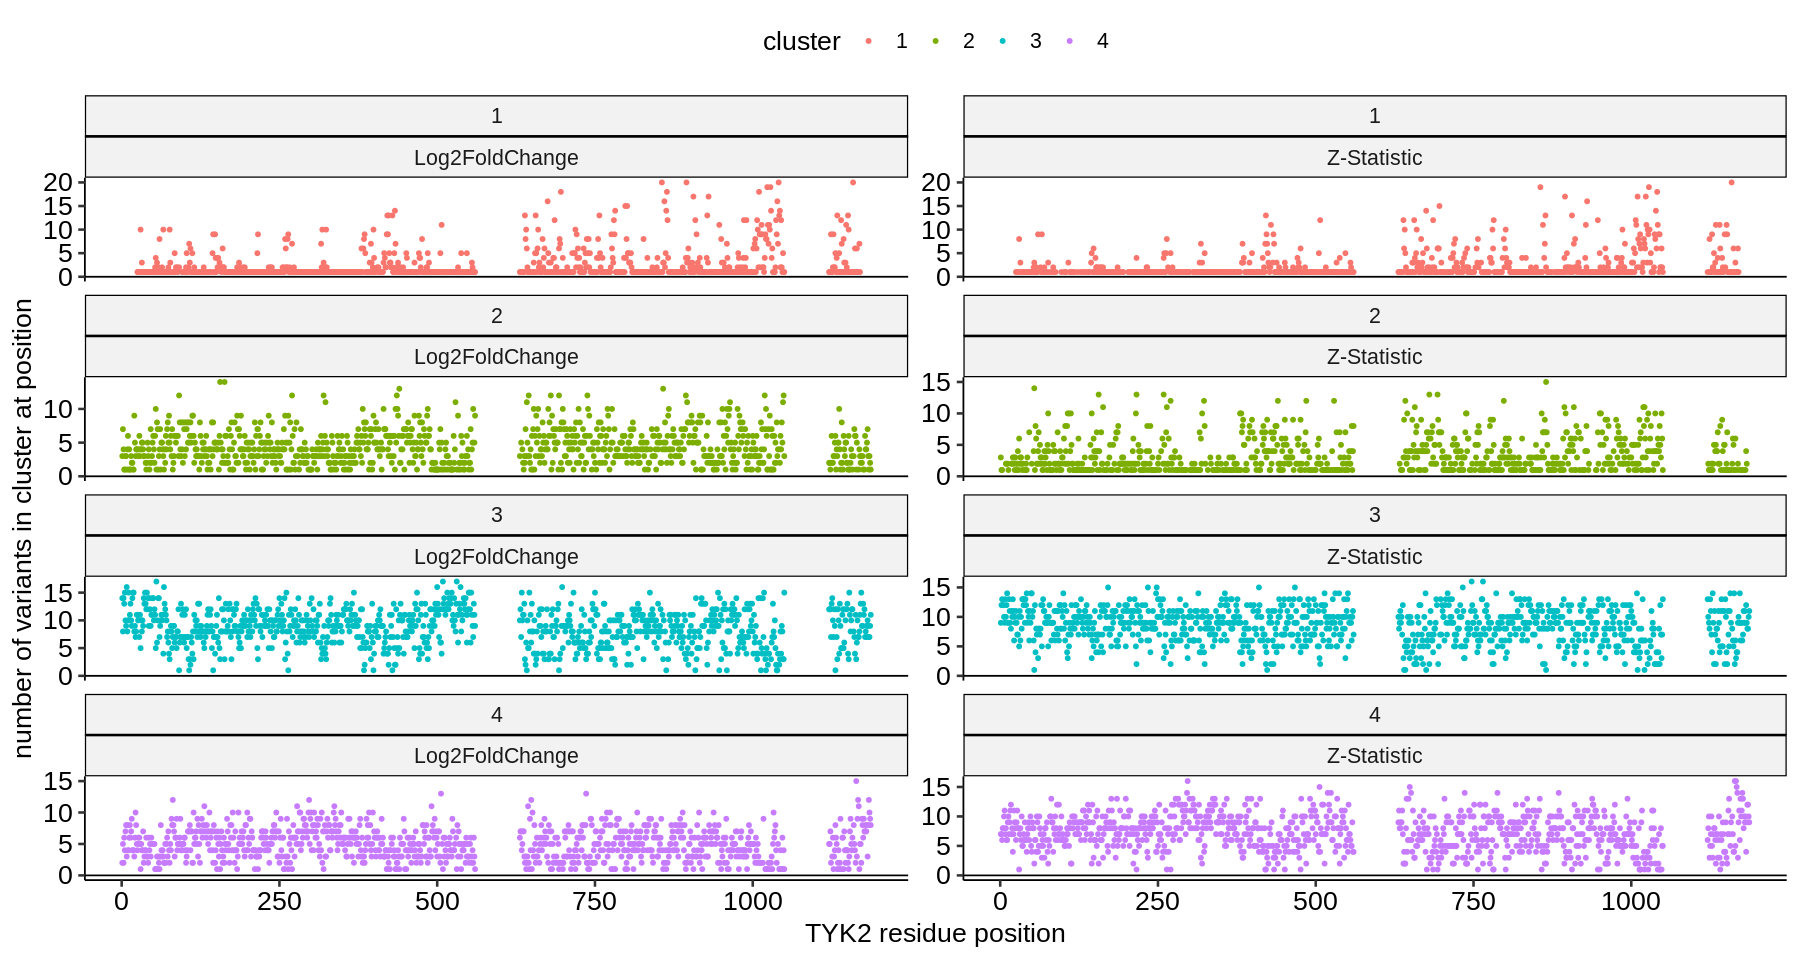

In [74]:
options(repr.plot.width = 15, repr.plot.height = 8)

joined_clust %>%
    rename("Log2FoldChange" = "display.x", "Z-Statistic" = "display.y") %>%
    pivot_longer(names_to = "group", values_to = "cluster", Log2FoldChange:`Z-Statistic`) %>%
    group_by(pos, group, cluster) %>%
    count() %>%
    ggplot() +
        geom_hline(yintercept = 0) +
        geom_point(aes(y = n, x = pos, color = as.factor(cluster)), size = 1) +
        theme_pubr(base_size = 16) +
        facet_wrap(~as.factor(cluster) + group, ncol = 2, scales = "free_y") +
        scale_color_discrete(name = "cluster") +
        ylab("number of variants in cluster at position") +
        xlab("TYK2 residue position")

#### Meta-Regression <a name="part2"></a>

Alternatively, if we expect the effects to change in a monotonic (meaning always increasing or decreasing with increasing concentration) or a linear fashion, we can use Bayesian meta-regression to model this change and explicitly test whether it is significantly different from zero:

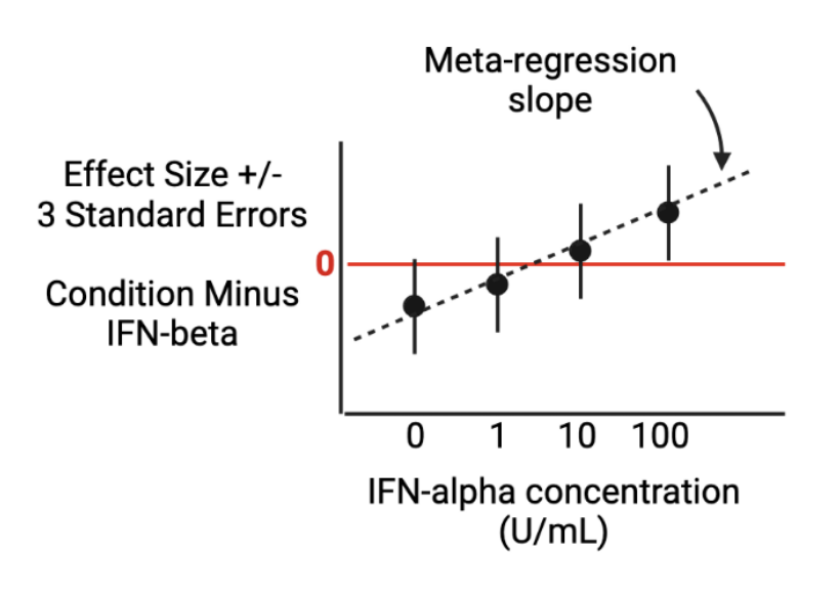

In [182]:
options(repr.plot.width = 7, repr.plot.height = 5)
img <- readPNG("metareg.png")
grid::grid.raster(img)

We can fit this model using `brms`, and one option is the linear slope shown above. Another, more flexible option available is monotonic regression (also called "isotonic" regression) that does not assume linearity, but only that the direction of the change from each lower to higher concentration step is the same (all positive or all negative).

It results in an estimate of the "general" monotonic effect, as well as a simplex that divides the maximum effect (between the largest and smallest concentrations) between each step. It is a bit easier to visualize with an example. Below, we extract one stop codon (randomly chosen at position 945) and show the monotonic model:

In [46]:
data <- sumstats %>% 
    filter(aa == "*",
           pos == 945,
           grepl(" - IFNbeta100", condition),
           !grepl("WithDrug100", condition)) %>%
    mutate(condition = gsub(" - IFNbeta100", "", condition))

coding <- tibble("condition" = c("None0", "IFNalpha1", "IFNalpha10", "IFNalpha100"),
                 "encoding" = c(1, 2, 3, 4))

data <- data %>% left_join(coding, by = "condition")

In [47]:
priors <- c(prior(normal(0,1), class = Intercept),
            prior(normal(0,1), class = b),
            prior(dirichlet(c(1,1,1)), class = simo, coef = moencoding1))

mod <- brm(log2FoldChange | se(std.error) ~ 1 + mo(encoding),
           data = data,
           prior = priors,
           iter = 5000,
           cores = 10,
           refresh = 0)

summary(mod)

Compiling Stan program...

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log2FoldChange | se(std.error) ~ 1 + mo(encoding) 
   Data: data (Number of observations: 4) 
  Draws: 4 chains, each with iter = 5000; warmup = 2500; thin = 1;
         total post-warmup draws = 10000

Population-Level Effects: 
           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     -0.32      0.21    -0.71     0.11 1.00     4137     4783
moencoding    -0.58      0.11    -0.79    -0.38 1.00     3942     4793

Simplex Parameters: 
               Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
moencoding1[1]     0.19      0.13     0.01     0.47 1.00     5449     3839
moencoding1[2]     0.56      0.17     0.21     0.88 1.00     5608     5598
moencoding1[3]     0.25      0.14     0.02     0.56 1.00     5362     3651

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.00      0.00     0.00     0.00   NA       NA       NA

Dr

We obtain a general "slope" estimate of -0.58, along with the "intercept" of -0.32 and the simplex parameters that define the proportion of the maximum predicted effect within each comparison. These results imply that most of the drop occurs between IFNalpha10 to IFNalpha100, and the change between those two conditions is about 2X the magnitude of the change between the other pairs. Let's see what it looks like - the red lines show the fitted intercept and slope:

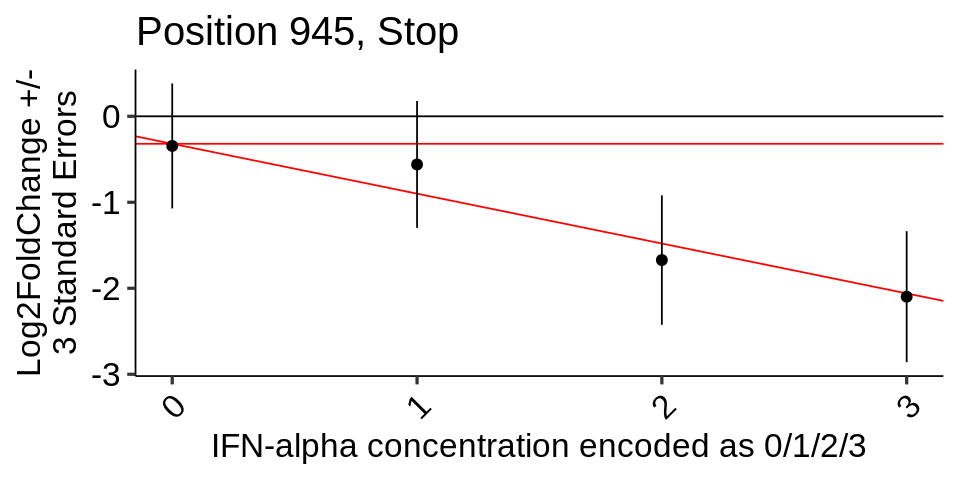

In [48]:
options(repr.plot.width = 8, repr.plot.height = 4)

data %>%
    mutate(condition = gsub(" - IFNbeta100", "", condition)) %>%
    ggplot() +
        geom_abline(slope = -0.58, intercept = -0.32, color = "red") +
        geom_hline(yintercept = -0.32, color = "red") +
        geom_pointrange(aes(x = encoding-1, y = log2FoldChange,
                            ymin = log2FoldChange - 3*std.error,
                            ymax = log2FoldChange + 3*std.error)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        geom_hline(yintercept = 0) +
        xlab("") +
        ylab("Log2FoldChange +/-\n3 Standard Errors") +
        xlab("IFN-alpha concentration encoded as 0/1/2/3") +
        ggtitle("Position 945, Stop")

In ths plot, the fold change and error bars are taken from the original summary statistics, and the diagonal line is the fitted monotonic slope parameter (with an intercept through zero). Additionally, we also see that the drop between IFNalpha10 and IFNalpha100 (1 and 2 in the plot) is indeed much larger than the 0->1 or 2->3 change, as the model summary described.

Using `brms`, we fit the monotonic model across all variants using the `IFNbeta100`-normalized summary statistics. This generates a new set of summary statistics, which we can characterize with the usual tools:

In [43]:
sumstats_brms_slope <- read_tsv("sumstats/tyk2_monotonic_sumstats.tsv") %>%
    filter(term == "bsp_moencoding") %>%
    separate(mut, c("aa", "pos"), sep = "_") %>%
    mutate(aa = if_else(aa == "*", "Stop", aa),
           statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sumstats_brms_slope %>%
    select(-term) %>%
    write_tsv("sumstats/tyk2_monotonic_sumstats_clean.tsv")

Rows: 146482 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): term, mut
dbl (2): estimate, std.error

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


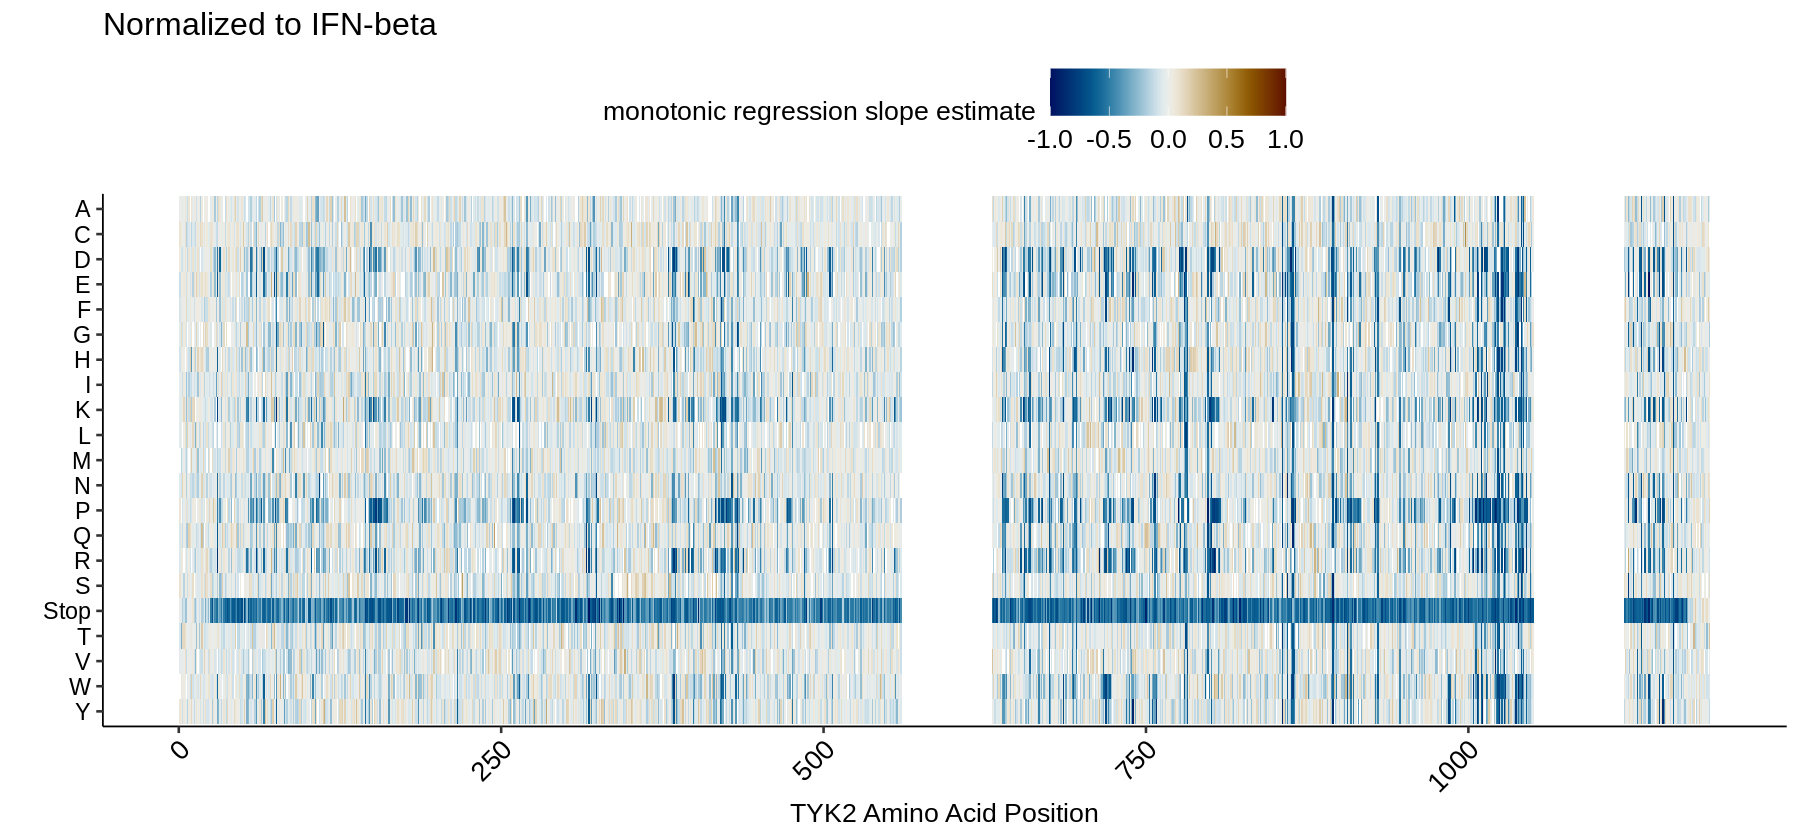

In [29]:
options(repr.plot.width = 15, repr.plot.height = 7)

sumstats_brms_slope  %>%
    rename("monotonic regression slope estimate" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = as.numeric(pos), y = fct_rev(aa), fill = `monotonic regression slope estimate`)) +
            scale_fill_scico_mid( limits = c(-1,1), palette = "vik", mid = 0, oob = squish) +
            new_scale_fill() +
            scale_fill_identity() +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=16),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            ggtitle("Normalized to IFN-beta")

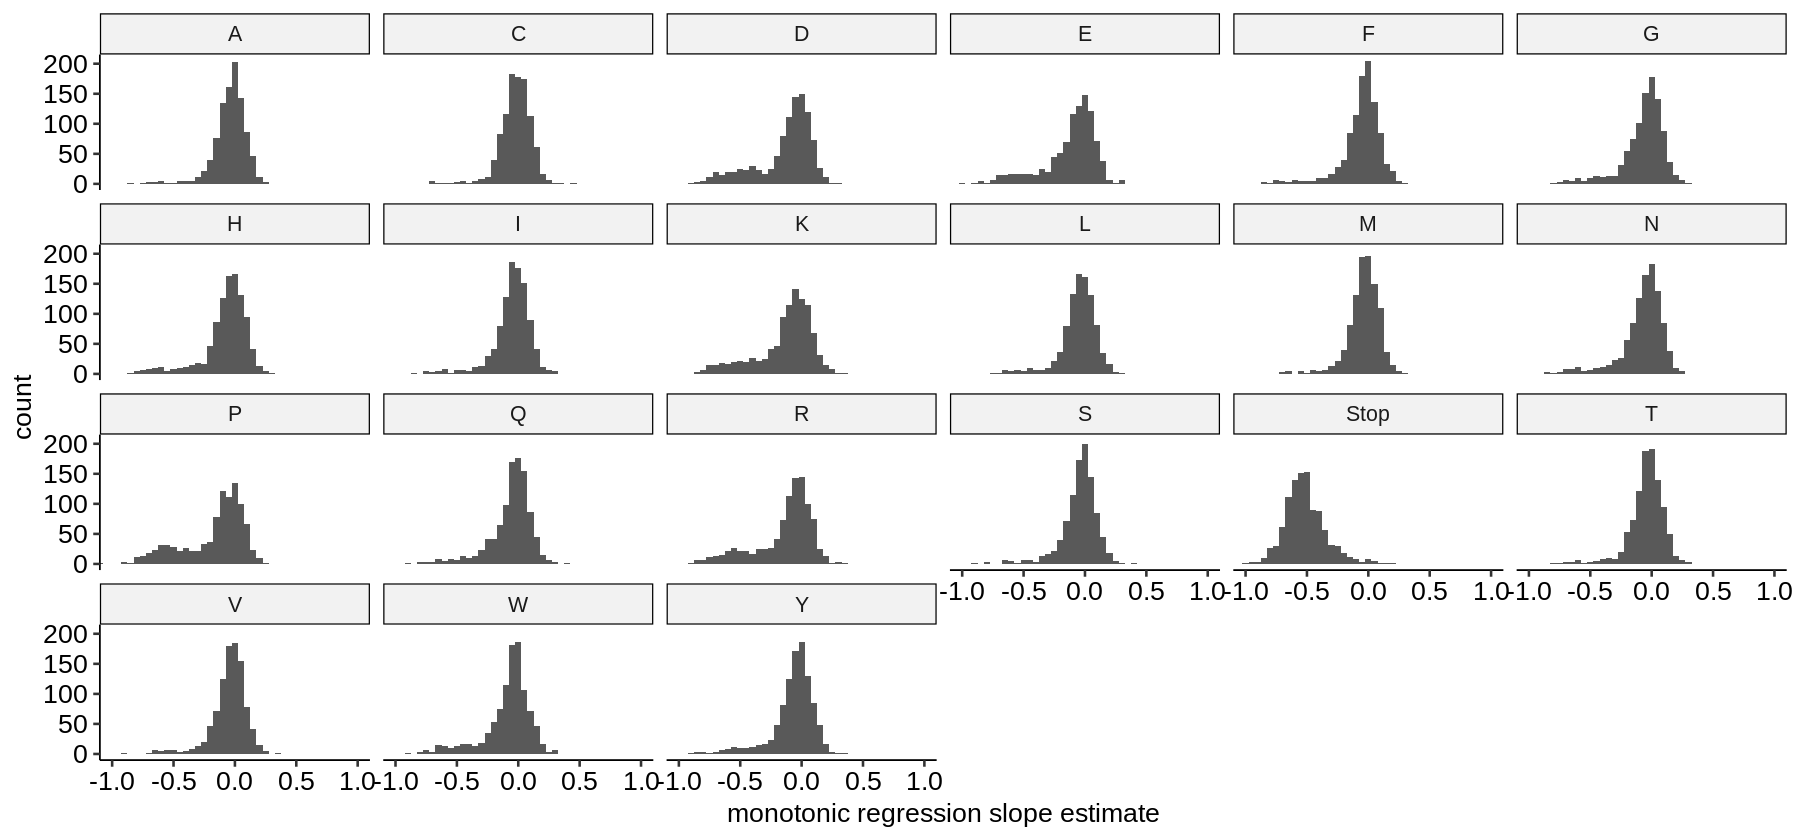

In [30]:
options(repr.plot.width = 15, repr.plot.height = 7)

sumstats_brms_slope %>%
    ggplot() +
        geom_histogram(aes(x = estimate), binwidth = 0.05) +
        theme_pubr(base_size = 16) +
        facet_wrap(~aa, nrow = 4) +
        coord_cartesian(xlim = c(-1,1)) +
        xlab("monotonic regression slope estimate")

We can extract and look at the top gain-of-function variants by adjusted p-value:

In [33]:
sumstats_brms_slope %>%
    filter(estimate > 0) %>%
    arrange(p.adj) %>%
    head(n=10) %>%
    kable("markdown")

top10_gof <- sumstats_brms_slope %>%
    filter(estimate > 0) %>%
    arrange(p.adj) %>%
    head(n=10)



|term           |  estimate| std.error|aa |pos  | statistic|   p.value|     p.adj|
|:--------------|---------:|---------:|:--|:----|---------:|---------:|---------:|
|bsp_moencoding | 0.2865809| 0.0892444|W  |544  |  3.211193| 0.0013219| 0.0127647|
|bsp_moencoding | 0.3035196| 0.1118880|H  |197  |  2.712710| 0.0066735| 0.0550673|
|bsp_moencoding | 0.3853863| 0.1456305|S  |220  |  2.646330| 0.0081370| 0.0656168|
|bsp_moencoding | 0.2605959| 0.0984989|H  |1168 |  2.645673| 0.0081529| 0.0656937|
|bsp_moencoding | 0.4726404| 0.1842144|C  |998  |  2.565708| 0.0102965| 0.0808198|
|bsp_moencoding | 0.1912397| 0.0795952|N  |530  |  2.402653| 0.0162766| 0.1204827|
|bsp_moencoding | 0.2793768| 0.1207457|W  |905  |  2.313762| 0.0206808| 0.1477520|
|bsp_moencoding | 0.2695466| 0.1169299|K  |905  |  2.305197| 0.0211555| 0.1505785|
|bsp_moencoding | 0.3207514| 0.1391744|C  |804  |  2.304672| 0.0211850| 0.1507292|
|bsp_moencoding | 0.1936619| 0.0845296|K  |551  |  2.291053| 0.0219603| 0.1552507|

We can see that only one is signifiant at a 5% FDR, which is 544W. Let's plot the original summary statistics, normalized to `IFNbeta100`, for these ten variants:

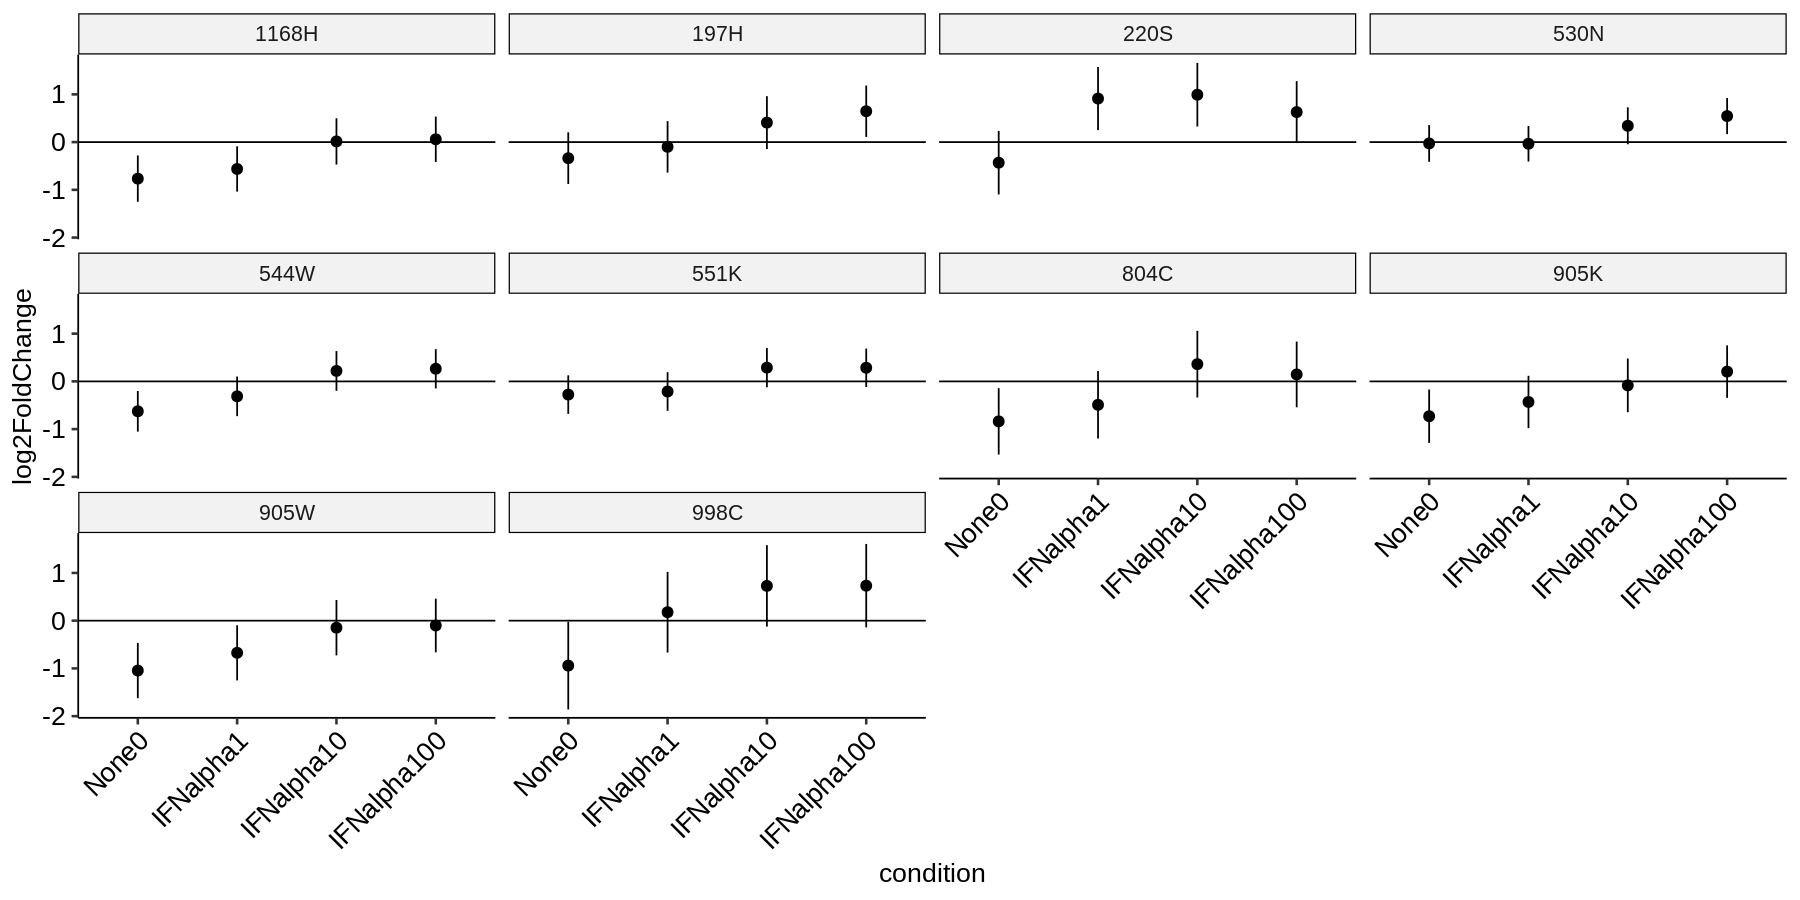

In [40]:
options(repr.plot.width = 15, repr.plot.height = 7.5)
sumstats %>%
    filter(str_c(pos, aa) %in% str_c(top10_gof$pos, top10_gof$aa),
           grepl(" - IFNbeta100", condition),
           !grepl("WithDrug", condition)) %>%
    mutate(condition = gsub(" - IFNbeta100", "", condition),
           condition = relevel(factor(condition), ref = "None0")) %>%
    ggplot() +
        geom_pointrange(aes(x = condition, y = log2FoldChange,
                            ymin = log2FoldChange - 2*std.error,
                            ymax = log2FoldChange + 2*std.error)) +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        facet_wrap(~str_c(pos, aa)) +
        geom_hline(yintercept = 0)

Indeed, these are the variants we had imagined retrieving - however, in most cases, the standard errors on the estimates result in the model being sub-significant for all gain-of-function cases except 544W, which not coincidentally has one of the smaller error bars across the shown variants.

#### BMS-986202 Concentration Gradient <a name="part3"></a>

Across several datasets, we now have variant effect profiles under varying concentrations of BMS-986202 (but the same concentration of IFN-alpha). So, we would like to view variants along the concentration axis, but aggregated in a similar way to the clustering above. 

In [61]:
sumstats3 <- read_tsv("../sumstats/TYK2/run3/tyk2-assay3.tsv") %>%
    filter(condition %in% c("IFNalphaWithDrug100 - None0")) %>%
    select(pos, aa, estimate, statistic, condition, p.adj) %>%
    mutate(condition = "IFNalpha+BMS-986202_1e-05")

sumstats4 <- read_tsv("../sumstats/TYK2/run4/tyk2-assay4.tsv") %>%
    filter(grepl("BMS", condition), condition != "IFNalpha+BMS-986202_3.6e-09 - None_0") %>%
    select(pos, aa, estimate, statistic, condition, p.adj) %>%
    mutate(condition = gsub(" .*", "", condition))

sumstats7 <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv") %>%
    filter(condition %in% c("IFNalpha100_0 - None_0")) %>%
    select(pos, aa, estimate, statistic, condition, p.adj) %>%
    mutate(condition = "IFNalpha+BMS-986202_0")

bms_stats <- bind_rows(sumstats3, sumstats4, sumstats7)

sig_vars <- bms_stats %>% filter(condition != "IFNalpha+BMS-986202_0",
                                 p.adj < 0.01,
                                 estimate > 0) %>%
    select(pos, aa) %>%
    distinct()

bms_stats <- inner_join(bms_stats, sig_vars) %>% select(-p.adj)

Rows: 237230 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 118600 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 94876 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, est

In [83]:
sumstat_mat_z <- bms_stats %>%
    group_by(pos, aa) %>%
    select(pos, aa, statistic, condition) %>%
    pivot_wider(names_from = condition, values_from = statistic) %>%
    drop_na()

sumstat_mat_lfc <- bms_stats %>%
    group_by(pos, aa) %>%
    select(pos, aa, estimate, condition) %>%
    pivot_wider(names_from = condition, values_from = estimate) %>%
    drop_na()

sumstat_mat_z$clusters <- kmeans(x = sumstat_mat_z[,-1:-2], centers = 3)$cluster
sumstat_mat_lfc$clusters <- kmeans(x = sumstat_mat_lfc[,-1:-2], centers = 3)$cluster
sumstat_mat_z$clusters <- sumstat_mat_lfc$clusters

lfc_clust_id <- sumstat_mat_lfc %>% 
    pivot_longer(names_to = "condition", values_to = "Log2FoldChange", 3:6) %>%
    group_by(clusters) %>%
    summarize(med = median(Log2FoldChange)) %>%
    mutate(order_lfc = order(med)) %>%
    select(-med) 

z_clust_id <- sumstat_mat_z %>% 
    pivot_longer(names_to = "condition", values_to = "statistic", 3:6) %>%
    group_by(clusters) %>%
    summarize(med = median(statistic)) %>%
    mutate(order_z = order(med)) %>%
    select(-med) 


clust_ids <- inner_join(lfc_clust_id, z_clust_id, by = "clusters") %>%
    rename("display" = "clusters")

In [88]:
cluster_conc_z <- sumstat_mat_z %>%
    pivot_longer(names_to = "condition", values_to = "statistic", 3:6) %>%
    mutate(condition = gsub("IFNalpha+BMS-986202_", "", condition, fixed = TRUE),
           condition = factor(condition, levels = c("0", "2e-08", "1e-06", "1e-05"))) %>%
    left_join(clust_ids, by = c("clusters" = "order_lfc")) %>% 
    ggplot() +
        geom_hline(yintercept = 0) +
        geom_line(aes(x = condition, y = statistic, group = paste0(pos, aa)), alpha = 0.2) +
        theme_pubr(base_size = 20) +
        xlab("BMS-986202 Concentration") + ylab("Z-Statistic (Mutant vs WT)\nNormalized to Untreated") +
        facet_wrap(~display, nrow = 1)

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-BMSConcCluster-Z.pdf",
       cluster_conc_z,
       width = 13, height = 5)

cluster_conc_lfc <- sumstat_mat_lfc %>%
    pivot_longer(names_to = "condition", values_to = "Log2FoldChange", 3:6) %>%
    mutate(condition = gsub("IFNalpha+BMS-986202_", "", condition, fixed = TRUE),
           condition = factor(condition, levels = c("0", "2e-08", "1e-06", "1e-05"))) %>%
    left_join(clust_ids, by = c("clusters" = "order_lfc")) %>% 
    ggplot() +
        geom_hline(yintercept = 0) +
        geom_line(aes(x = condition, y = Log2FoldChange, group = paste0(pos, aa)), alpha = 0.2) +
        theme_pubr(base_size = 20) +
        xlab("BMS-986202 Concentration") + ylab("Log2 Fold Change (Mutant vs WT)\nNormalized to Untreated") +
        facet_wrap(~display, nrow = 1)

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-BMSConcCluster-L2FC.pdf",
       cluster_conc_lfc,
       width = 13, height = 5)

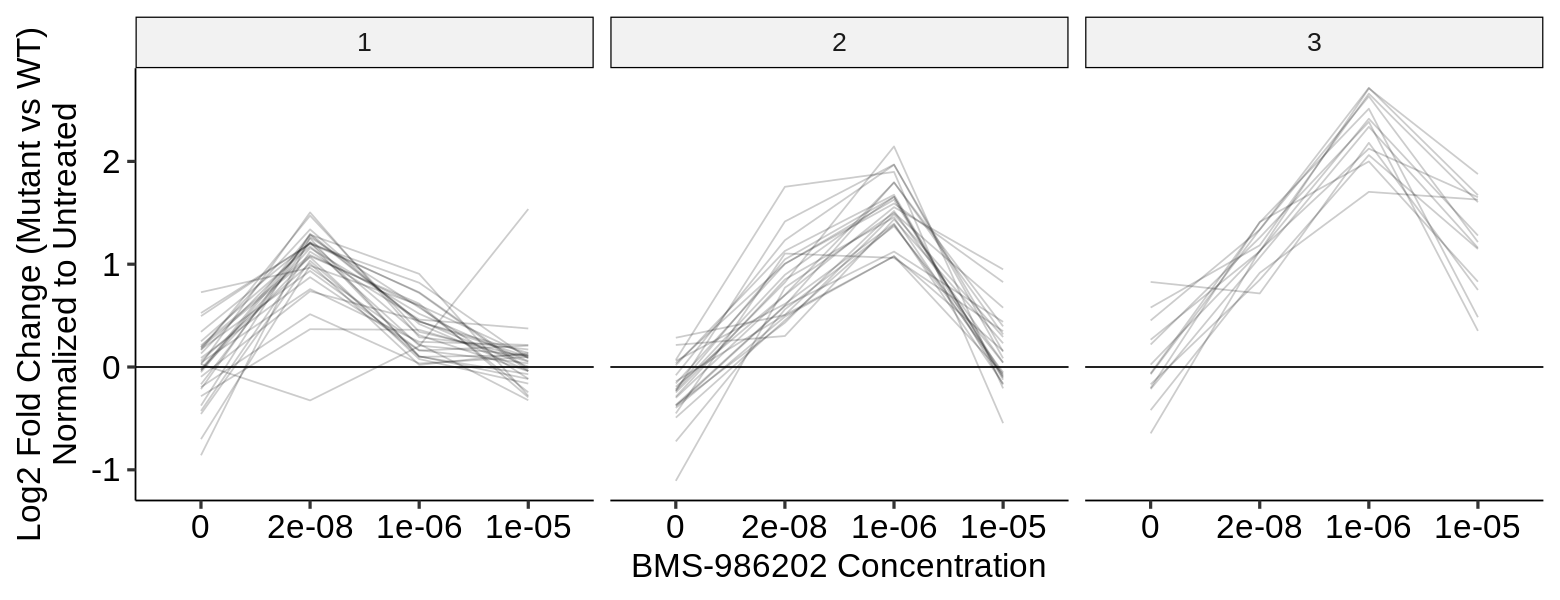

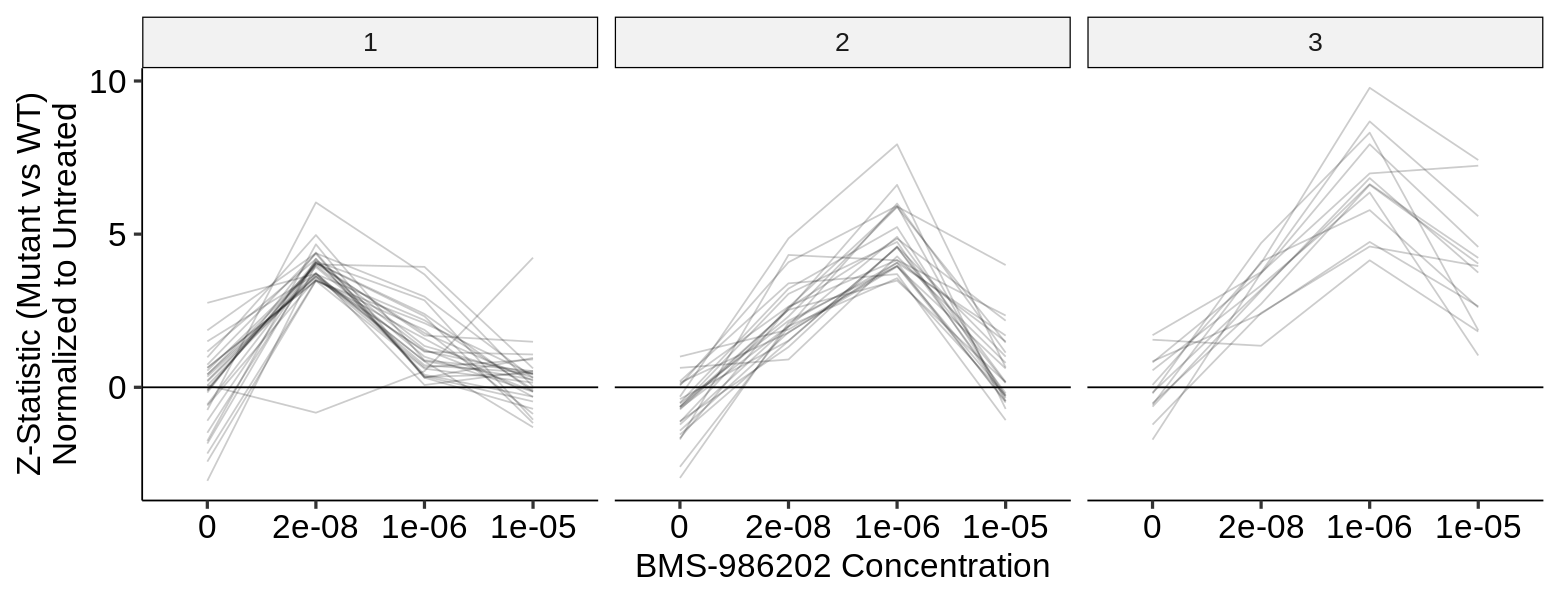

In [87]:
options(repr.plot.width = 13, repr.plot.height = 5)
cluster_conc_lfc
cluster_conc_z